In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import torch
import pyro.distributions as dist

import time

In [2]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO, TraceEnum_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal


def svi(temperature_model, guide, obs, num_steps = 5000, plot = False):
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model=temperature_model,
                         guide=guide,
                         optim=SGD({"lr": 0.001, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))

    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()

In [3]:
pyro.clear_param_store()

obs = {'counts_1': torch.tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
       'counts_2': torch.tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
      }

def model(obs):
    p_1 = pyro.param('p_1', torch.tensor(0.1))
    p_2 = pyro.param('p_2', torch.tensor(0.1))
    coupling = pyro.param('coupling', torch.tensor(0.7))
    for i in range(obs['counts_2'].shape[0]):
        spike_1 = pyro.sample(f'spike_1_{i}', dist.Bernoulli(p_1), obs=obs['counts_1'][i])
        spike_2 = pyro.sample(f'spike_2_{i}', dist.Bernoulli(p_2+coupling*spike_1), obs=obs['counts_2'][i])

def guide(obs):
    pass
#     for i in range(obs['counts_2'].shape[0]):
#         spike = pyro.sample(f'spike_1_{i}', dist.Bernoulli(0.5))
        

SyntaxError: invalid syntax (<ipython-input-3-425dd52c5971>, line 12)

In [42]:
#Run inference
svi(model, guide, obs, num_steps=1000)

#Print results
print('Coupling:', pyro.param("coupling").item())
print('Firing neuron 1:', pyro.param("p_1").item())
print('Firing neuron 2:', pyro.param("p_2").item())

Coupling: 0.8193784356117249
Firing neuron 1: 0.31249985098838806
Firing neuron 2: 0.18181826174259186


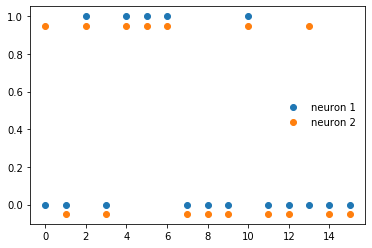

In [43]:
times = range(obs['counts_2'].shape[0])

plt.figure()
plt.plot(times, np.array(obs['counts_1']), 'o', label='neuron 1')
plt.plot(times, np.array(obs['counts_2'])-0.05, 'o', label='neuron 2')
plt.legend(framealpha=0, loc='center right')
plt.show()

In [44]:
# np.mean(np.array(obs['counts_1']))

In [45]:
# from sklearn.linear_model import LogisticRegression

In [46]:
# mod = LogisticRegression(C=1e5)

In [47]:
# f = mod.fit(np.array(obs['counts_1']).reshape(-1, 1), np.array(obs['counts_2']))

In [48]:
# logistic = lambda x: 1 / (1 + np.exp(-x))
# logistic(f.coef_ + f.intercept_) - logistic(f.intercept_)

In [49]:
# y = logistic(intercept + coef * x)

In [50]:
pyro.clear_param_store()

def model(obs):
    p_1 = pyro.sample('p_1', dist.Normal(0.0, 0.3))
    p_2 = pyro.sample('p_2', dist.Normal(0.0, 0.3))
    coupling = pyro.sample('coupling', dist.Normal(0.7, 0.3))
#     p_1 = pyro.sample('p_1', dist.Beta(1.0, 1.))
#     p_2 = pyro.sample('p_2', dist.Beta(1.0, 1.))
#     coupling = pyro.sample('coupling', dist.Beta(1., 1.))
    for i in range(obs['counts_2'].shape[0]):
        spike_1 = pyro.sample(f'spike_1_{i}', dist.Bernoulli(p_1), obs=obs['counts_1'][i])
        spike_2 = pyro.sample(f'spike_2_{i}', dist.Bernoulli(p_2+coupling*spike_1), obs=obs['counts_2'][i])

        
def guide(obs):
    mean_p_1 = pyro.param("mean_p_1", torch.tensor(0.1), constraint=constraints.positive)
    scale_p1 = pyro.param("scale_p_1", torch.tensor(.2), constraint=constraints.positive)
    p_1 = pyro.sample('p_1', dist.Normal(mean_p_1, scale_p1))
    
    mean_p_2 = pyro.param("mean_p_2", torch.tensor(0.3), constraint=constraints.positive)
    scale_p2 = pyro.param("scale_p_2", torch.tensor(.2), constraint=constraints.positive)
    p_2 = pyro.sample('p_2', dist.Normal(mean_p_2, scale_p1))
    
    mean_coupling = pyro.param("mean_coupling", torch.tensor(0.8), constraint=constraints.positive)
    scale_coupling = pyro.param("scale_coupling", torch.tensor(.2), constraint=constraints.positive)
    coupling = pyro.sample('coupling', dist.Normal(mean_p_1, scale_p1))

        
#     mean_p_1 = pyro.param("mean_p_1", torch.tensor(1.), constraint=constraints.positive)
#     scale_p1 = pyro.param("scale_p_1", torch.tensor(1.), constraint=constraints.positive)
#     p_1 = pyro.sample('p_1', dist.Beta(mean_p_1, scale_p1))
    
#     mean_p_2 = pyro.param("mean_p_2", torch.tensor(1.), constraint=constraints.positive)
#     scale_p2 = pyro.param("scale_p_2", torch.tensor(1.), constraint=constraints.positive)
#     p_2 = pyro.sample('p_2', dist.Beta(mean_p_2, scale_p1))
    
#     mean_coupling = pyro.param("mean_coupling", torch.tensor(0.8), constraint=constraints.positive)
#     scale_coupling = pyro.param("scale_coupling", torch.tensor(.2), constraint=constraints.positive)
#     coupling = pyro.sample('coupling', dist.Beta(mean_p_1, scale_p1))

In [51]:
#Run inference
svi(model, guide, obs, num_steps=1000)

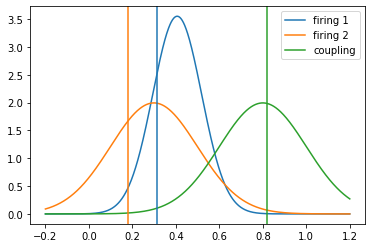

In [52]:
x = np.linspace(-0.2, 1.2, 1000)

pdf_p_1 = np.exp(np.array(dist.Normal(pyro.param('mean_p_1').item(),
                pyro.param('scale_p_1').item()).log_prob(torch.tensor(x))))

pdf_p_2 = np.exp(np.array(dist.Normal(pyro.param('mean_p_2').item(),
                pyro.param('scale_p_2').item()).log_prob(torch.tensor(x))))

pdf_coupling = np.exp(np.array(dist.Normal(pyro.param('mean_coupling').item(),
                pyro.param('scale_coupling').item()).log_prob(torch.tensor(x))))

plt.figure()
plt.plot(x, np.array(pdf_p_1), label='firing 1')
plt.plot(x, np.array(pdf_p_2), label='firing 2')
plt.plot(x, np.array(pdf_coupling), label='coupling')
plt.axvline(x=0.31249985098838806, color='C0')
plt.axvline(x=0.18181826174259186, color='C1')
plt.axvline(x=0.8193784356117249, color='C2')
plt.legend()
plt.show()